## Tarea 2
### Métodos con múltiples pasos

1. Suponga que un estudiante es portador de un virus y regresa a su aislado campus de 1000 estudiantes. Si se supone que la razón con que se propaga el virus es proporcional no sólo a la cantidad x de estudiantes infectados sino también a la cantidad de estudiantes no infectados. Determine la cantidad de estudiantes infectados después de 12 dı́as.
    Suponiendo que nadie deja el campus mientras dura la enfermedad, debemos resolver el siguiente problema de valor inicial

    \begin{equation}
    \frac{dx}{dt} = kx (1000-x)\, ,x(0)=1\, ,k=0.0009906
    \end{equation}

    Encuentre una solución aproximada aplicando el método predictor-corrector de Adams-Bashforth-Moulton de cuarto orden con $h = 1$. El algoritmo se basa en el método Adams-Bashforth de cuarto orden como predictor y el método de Adams-Moulton como corrector, con los valores iniciales obtenidos del método Runge-Kutta de cuarto orden (RK4).
    
    La solución analítica para este problema es:
    \begin{equation}
    x(t) = \frac{1000}{1+999e^{-1000kt}}
    \end{equation}
    
    Grafique el número de estudiantes infectados en función del tiempo, usando los datos obtenidos mediantes la solución analítica y los 4 métodos utilizados.

En este caso tenemos que $f(x,t) = kx(1000-x)$.

Para implementar los métodos de Adams-Bashfort, Adams-Moulton y predictor-corrector es necesario generar los puntos iniciales haciendo uso de RK4.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

k = 0.0009906
f = lambda x: k*x*(1000-x)

def analitica(t):
    return 1000/(1+999*np.exp(-1000*k*t))

In [17]:
def rk4(f, inicio, tiempo, h):
    """
    Soluciona una ecuación diferencial de una variable por el método de Runge-Kutta de 
    cuarto orden.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    T = np.arange(inicio[0], tiempo, h)
    Y = np.zeros(len(T))
    Y[0] = inicio[1]
    
    # Aplica Runge-Kutta de orden 4
    for i in range(len(T)-1):
        # Define los coeficientes
        k1 = f(Y[i])
        k2 = f(Y[i] + h*k1/2)
        k3 = f(Y[i] + h*k2/2)
        k4 = f(Y[i] + h*k3)
        # Calcula el resultado final
        Y[i+1] = Y[i] + h*(k1 + 2*k2 + 2*k3 + k4)/6
    
    return T, Y

In [18]:
def ab4(f, inicio, tiempo, h):
    """
    Soluciona una ecuación diferencial de una variable por el método de Adams-Bashforth de 
    cuarto orden.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    T = np.arange(inicio[0], tiempo, h)
    Y = np.zeros(len(T))
    Y[0] = inicio[1]
    
    #Determinamos los siguientes 3 pasos haciendo uso de RK4
    Y[0:4] = rk4(f, [T[0],Y[0]], 4*h, h)[1]
    
    # Aplica Adams-Bashforth
    for i in range(3,len(T)-1):
        Y[i+1] = Y[i]+h/24*(55*f(Y[i])-59*f(Y[i-1])+37*f(Y[i-2])-9*f(Y[i-3]))
    
    return T, Y

In [19]:
def am3rk4(f, inicio, tiempo, h):
    """
    Soluciona una ecuación diferencial de una variable mediante una corrección a la solución
    dada por Runge-Kutta 4 mediante Adams-Bashforth.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    T = np.arange(inicio[0], tiempo, h)
    YRK = np.zeros(len(T))
    Y = np.zeros(len(T))
    YRK[0] = inicio[1]
    
    #Determinamos los siguientes 2 pasos haciendo uso de RK4
    YRK = rk4(f,inicio, tiempo, h)[1]
    Y[0:3] = YRK[0:3]
    
    # Aplica Adams-Bashforth
    for i in range(2,len(T)-1):
        Y[i+1] = Y[i]+h/24*(9*f(YRK[i+1])+19*f(Y[i])-5*f(Y[i-1])+f(Y[i-2]))
    
    return T, Y

In [20]:
def Fixed_point(g, p0, w, tol=1.0e-10,  Nmax=10000):
    for i in range(Nmax):
        p = g(p0, *w)
        #print (i, p, np.abs(p-p0)) 
        if (np.abs(p-p0) < tol ): break
        p0 = p
    return p

In [21]:
def am3fp(f, inicio, tiempo, h):
    """
    Esta función implementa el método de Adams-Moulton hallando la solución a cada paso por el
    método de punto fijo.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    eq_sol = lambda x, w0, w1, w2: w0+h/24*(9*f(x)+19*f(w0)-5*f(w1)+f(w2))
    
    T = np.arange(inicio[0], tiempo, h)
    Y = np.zeros(len(T))
    Y[0] = inicio[1]
    
    #Determinamos los siguientes 2 pasos haciendo uso de RK4
    Y[0:3] = rk4(f, [T[0],Y[0]], 3*h, h)[1]
    
    # Aplica Adams-Bashforth
    for i in range(2,len(T)-1):
        Y[i+1] = Fixed_point(eq_sol, Y[i], [Y[i],Y[i-1],Y[i-2]])
    
    return T, Y

In [22]:
def abm(f, inicio, tiempo, h):
    """
    Soluciona una ecuación diferencial de una variable por un método predictor-corrector
    basado en una predicción por Adams-Bashforth y una corrección por Adams-Moulton.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    T = np.arange(inicio[0], tiempo, h)
    Y = np.zeros(len(T))
    Y[0] = inicio[1]
    
    #Determinamos los siguientes 3 pasos haciendo uso de RK4
    Y[0:4] = rk4(f, [T[0],Y[0]], 4*h, h)[1]
    
    # Aplica Adams-Bashforth
    for i in range(3,len(T)-1):
        w4p = Y[i]+h/24*(55*f(Y[i])-59*f(Y[i-1])+37*f(Y[i-2])-9*f(Y[i-3]))
        Y[i+1] = Y[i]+h/24*(9*f(w4p)+19*f(Y[i])-5*f(Y[i-1])+f(Y[i-2]))
    return T, Y

In [23]:
t, y = ab4(f, [0,1], 13, 1)
t4, y4 = rk4(f, [0,1], 13, 1)
t3, y3 = am3rk4(f, [0,1], 13, 1)
yt = analitica(t)
t, y3fp = am3fp(f, [0,1], 13, 1)
tp, ypm = abm(f, [0,1], 13, 1)

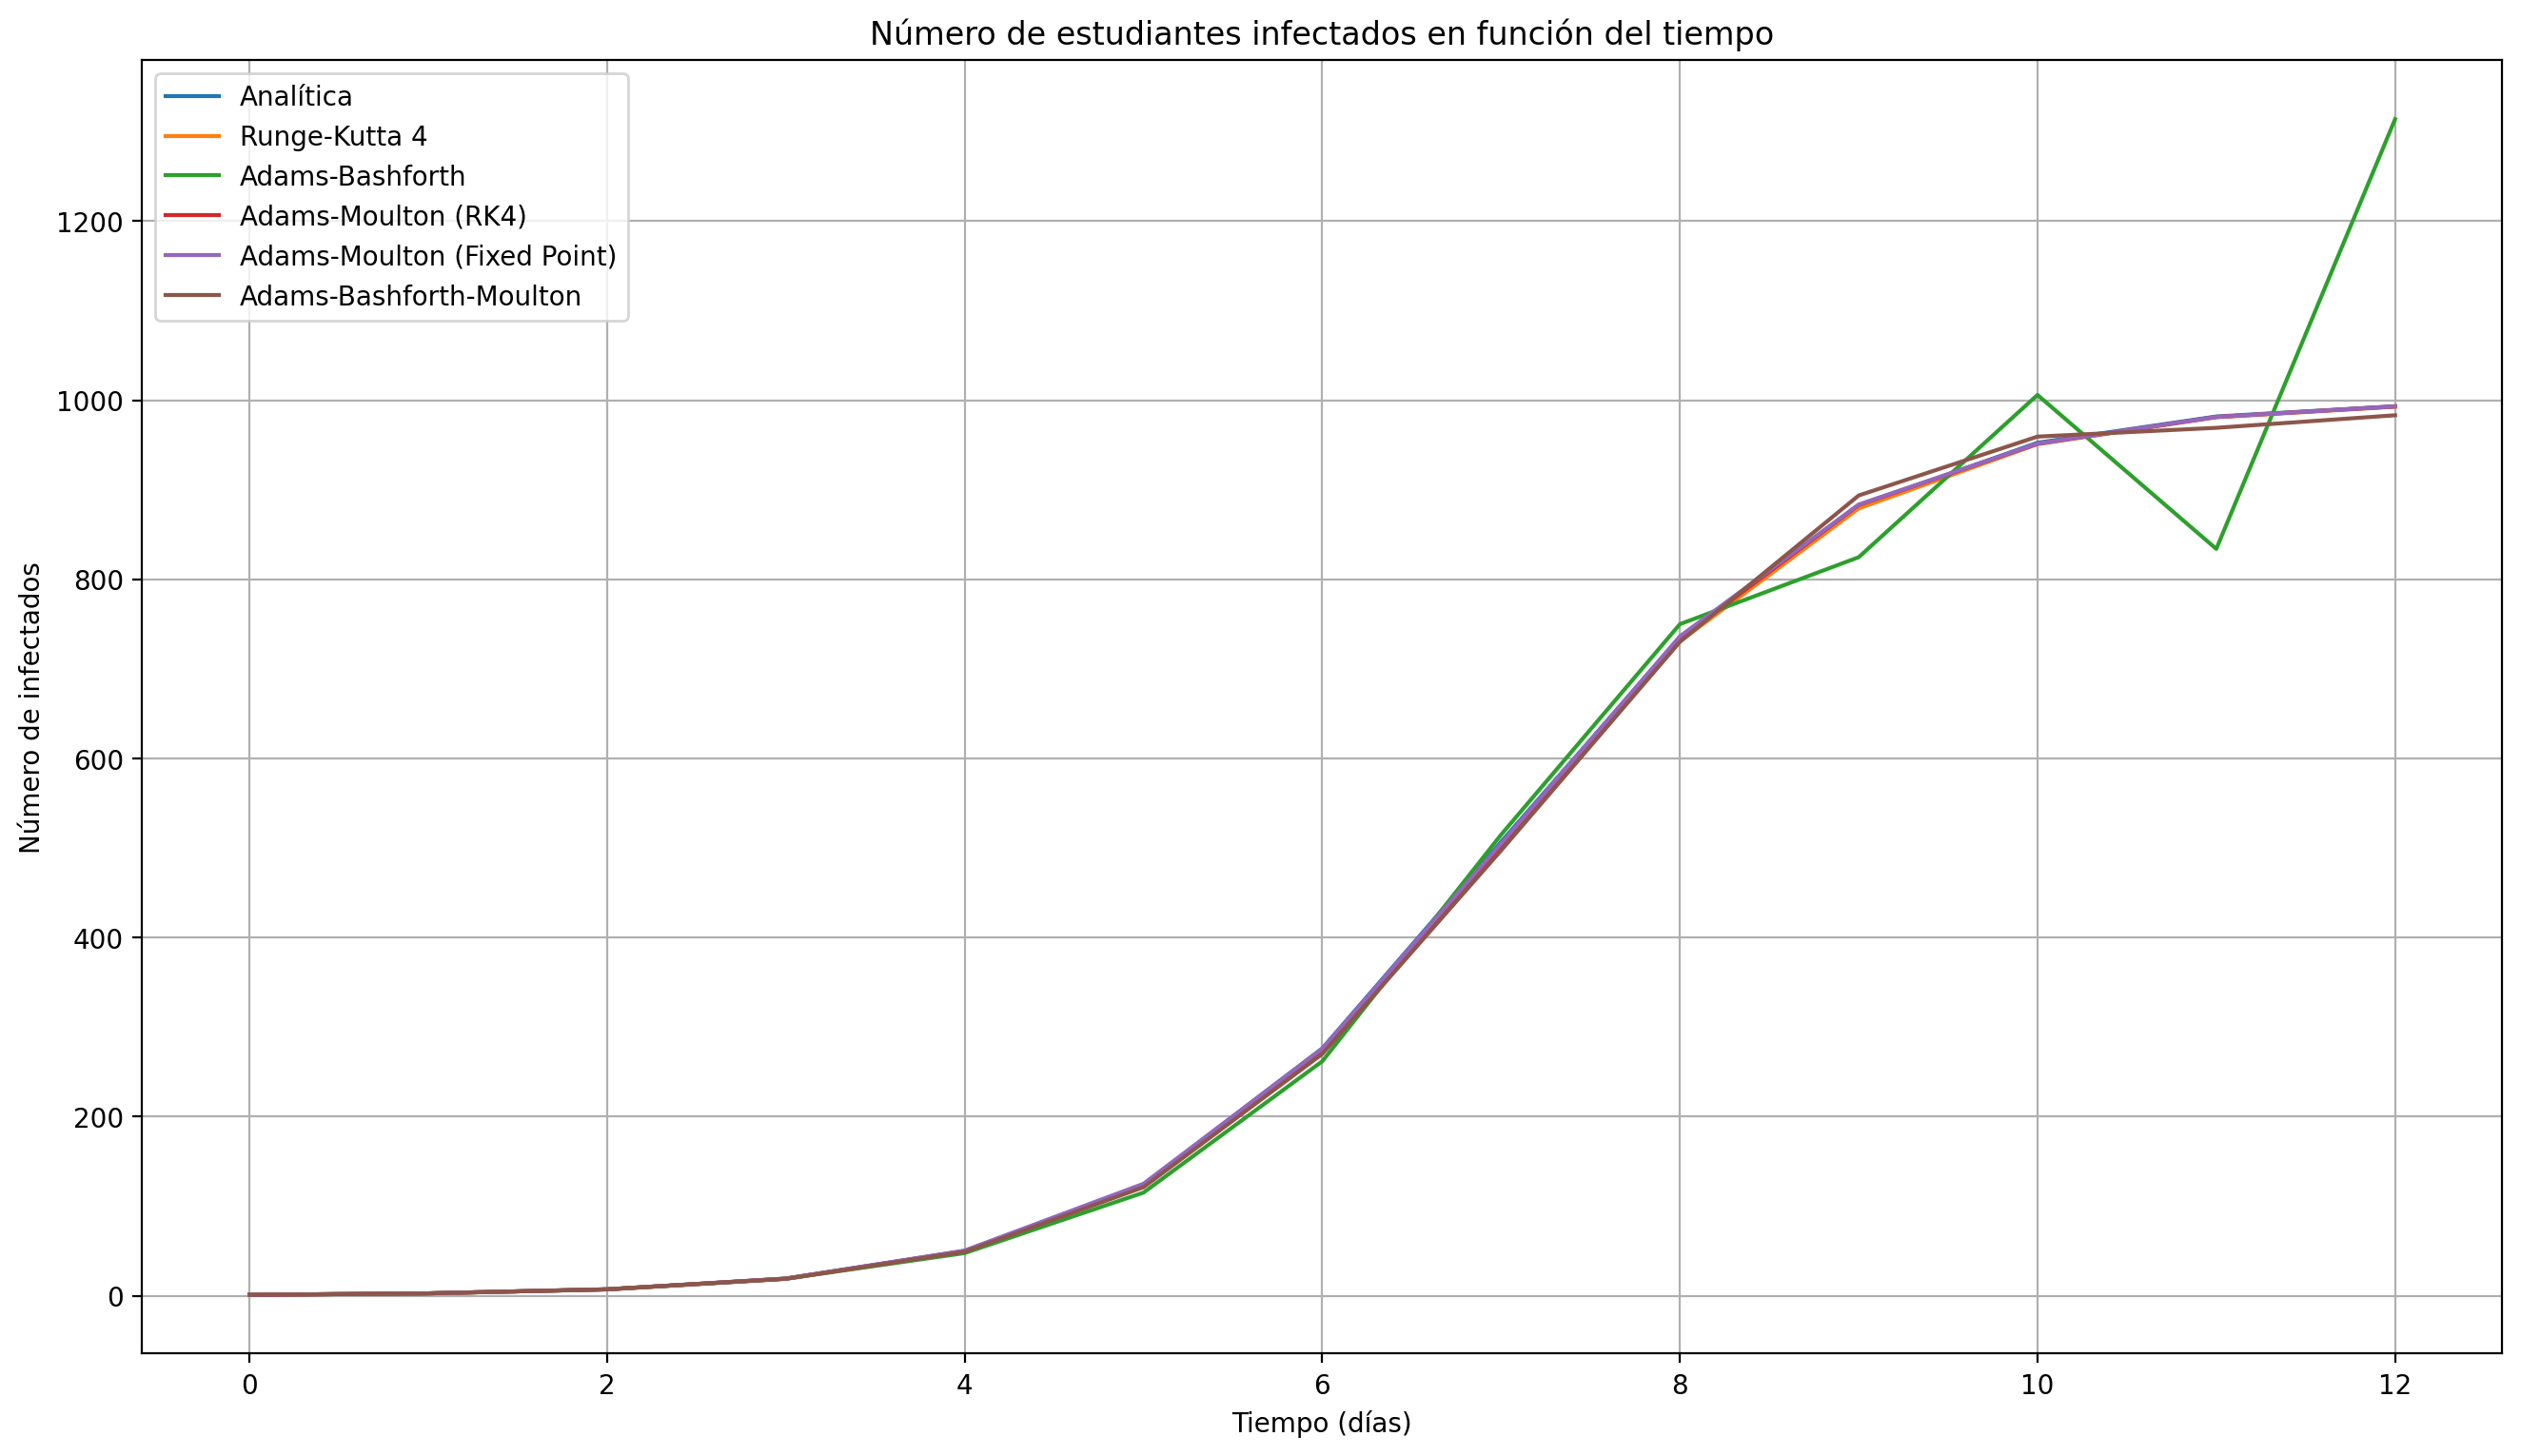

In [24]:
plt.figure(figsize=(16,9), dpi=200)
plt.title("Número de estudiantes infectados en función del tiempo")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de infectados")
plt.grid()

plt.plot(t, yt, label="Analítica")
plt.plot(t4, y4, label = "Runge-Kutta 4")
plt.plot(t, y, label="Adams-Bashforth")
plt.plot(t, y3, label="Adams-Moulton (RK4)")
plt.plot(t, y3fp, label= "Adams-Moulton (Fixed Point)")
plt.plot(t, ypm, label = "Adams-Bashforth-Moulton")
plt.legend()

In [25]:
def error(y):
    return abs(y-yt)

In [26]:
tabla = pd.DataFrame({"Día" : t, "Solución analítica" : yt, "Runge-Kutta" : y4, 
                      "Error(RK4)" : error(y4), "Adams-Bashforth" : y, "Error(AB)" : error(y),
                      "Adams-Moulton (RK4)" : y3, "Error(AM-RK4)": error(y3), 
                      "Adams-Moulton (Roots)" : y3fp, "Error (AM-FP)" : error(y3fp),
                      "Adams-Bashforth-Moulton": ypm, "Error (ABM)" : error(ypm)})

In [27]:
tabla

,Día,Solución analítica,Runge-Kutta,Error(RK4),Adams-Bashforth,Error(AB),Adams-Moulton (RK4),Error(AM-RK4),Adams-Moulton (Roots),Error (AM-FP),Adams-Bashforth-Moulton,Error (ABM)
0,0,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000
1,1,2.688299,2.678928,0.009371,2.678928,0.009371,2.678928,0.009371,2.678928,0.009371,2.678928,0.009371
2,2,7.206389,7.156728,0.049661,7.156728,0.049661,7.156728,0.049661,7.156728,0.049661,7.156728,0.049661
3,3,19.171839,18.978531,0.193308,18.978531,0.193308,19.135148,0.036691,19.222211,0.050372,18.978531,0.193308
4,4,50.004000,49.368632,0.635368,47.650118,2.353881,49.931970,0.072030,50.444437,0.440437,49.080762,0.923238
5,5,124.144515,122.408627,1.735888,115.186453,8.958062,123.460078,0.684437,125.057225,0.912710,121.233737,2.910777
6,6,276.247000,272.696146,3.550855,261.838719,14.408281,272.987343,3.259657,275.985526,0.261474,270.018443,6.228557
7,7,506.860875,502.182535,4.678340,514.798429,7.937554,501.120347,5.740527,504.943033,1.917842,497.218195,9.642679
8,8,734.591657,730.784302,3.807355,749.944241,15.352584,733.767505,0.824153,736.372687,1.781030,730.189690,4.401967
9,9,881.701787,879.177508,2.524279,824.693992,57.007795,883.025896,1.324109,883.505080,1.803293,893.628681,11.926894


2. Es posible realizar un control adaptativo de paso en el método predictor-corrector realizado en el problema 1. Use un $h_{max} = 1$, $h_{min} = 0.1$ y una tolerancia de $TOL = 10^{−5}$ para encontrar la solución aproximada de $x(t)$.

In [47]:
def abm_ada(f, inicio, tiempo, h0):
    """
    Soluciona una ecuación diferencial de una variable por un método predictor-corrector
    basado en una predicción por Adams-Bashforth y una corrección por Adams-Moulton.
    f: función de la derivada
    inicio: array, tupla o lista con las condiciones iniciales. El primer elemento corresponde
    al tiempo inicial.
    tiempo: float, tiempo final
    h: paso
    """
    
    T = np.zeros(4)
    Y = np.zeros(len(T))
    Y[0] = inicio[1]
    
    #Determinamos los siguientes 3 pasos haciendo uso de RK4
    h = h0
    Y[0:4] = rk4(f, [T[0],Y[0]], 4*h, h)[1]
    i = 3
    iterations = 0
    
    while T[i]<tiempo:
        w4p = Y[i]+h/24*(55*f(Y[i])-59*f(Y[i-1])+37*f(Y[i-2])-9*f(Y[i-3]))
        w4c = Y[i]+h/24*(9*f(w4p)+19*f(Y[i])-5*f(Y[i-1])+f(Y[i-2]))
        
        eps = 19/(270*h)*abs(w4p-w4c)
        
        
        if eps<1e-5:
            Y = np.append(Y, w4c)
            T = np.append(T, T[i]+h)
            i += 1

        
        q = (1e-5/(2*eps))**(1/4)
        
        if (q <= 0.1): h = 0.1*h   # (error grande) 0.1 es el mínimo valor impuesto para q
        elif (q >= 5): h = 5.*h    # 5 es el máximo valor impuesto para q
        else:          h = q*h  
        
        
        if h > 1:
            h = 1
        #elif h < 0.1:
        #    h = 0.1
            
        
        iterations+=1
        #if iterations>20000:
        #    break
        
    return T, Y

In [48]:
tada, yada = abm_ada(f, [0,1], 13, 1)
yt = analitica(tada)

<ipython-input-47-52d0f53b8a07>:34: RuntimeWarning: divide by zero encountered in double_scalars
  q = (1e-5/(2*eps))**(1/4)


KeyboardInterrupt: 

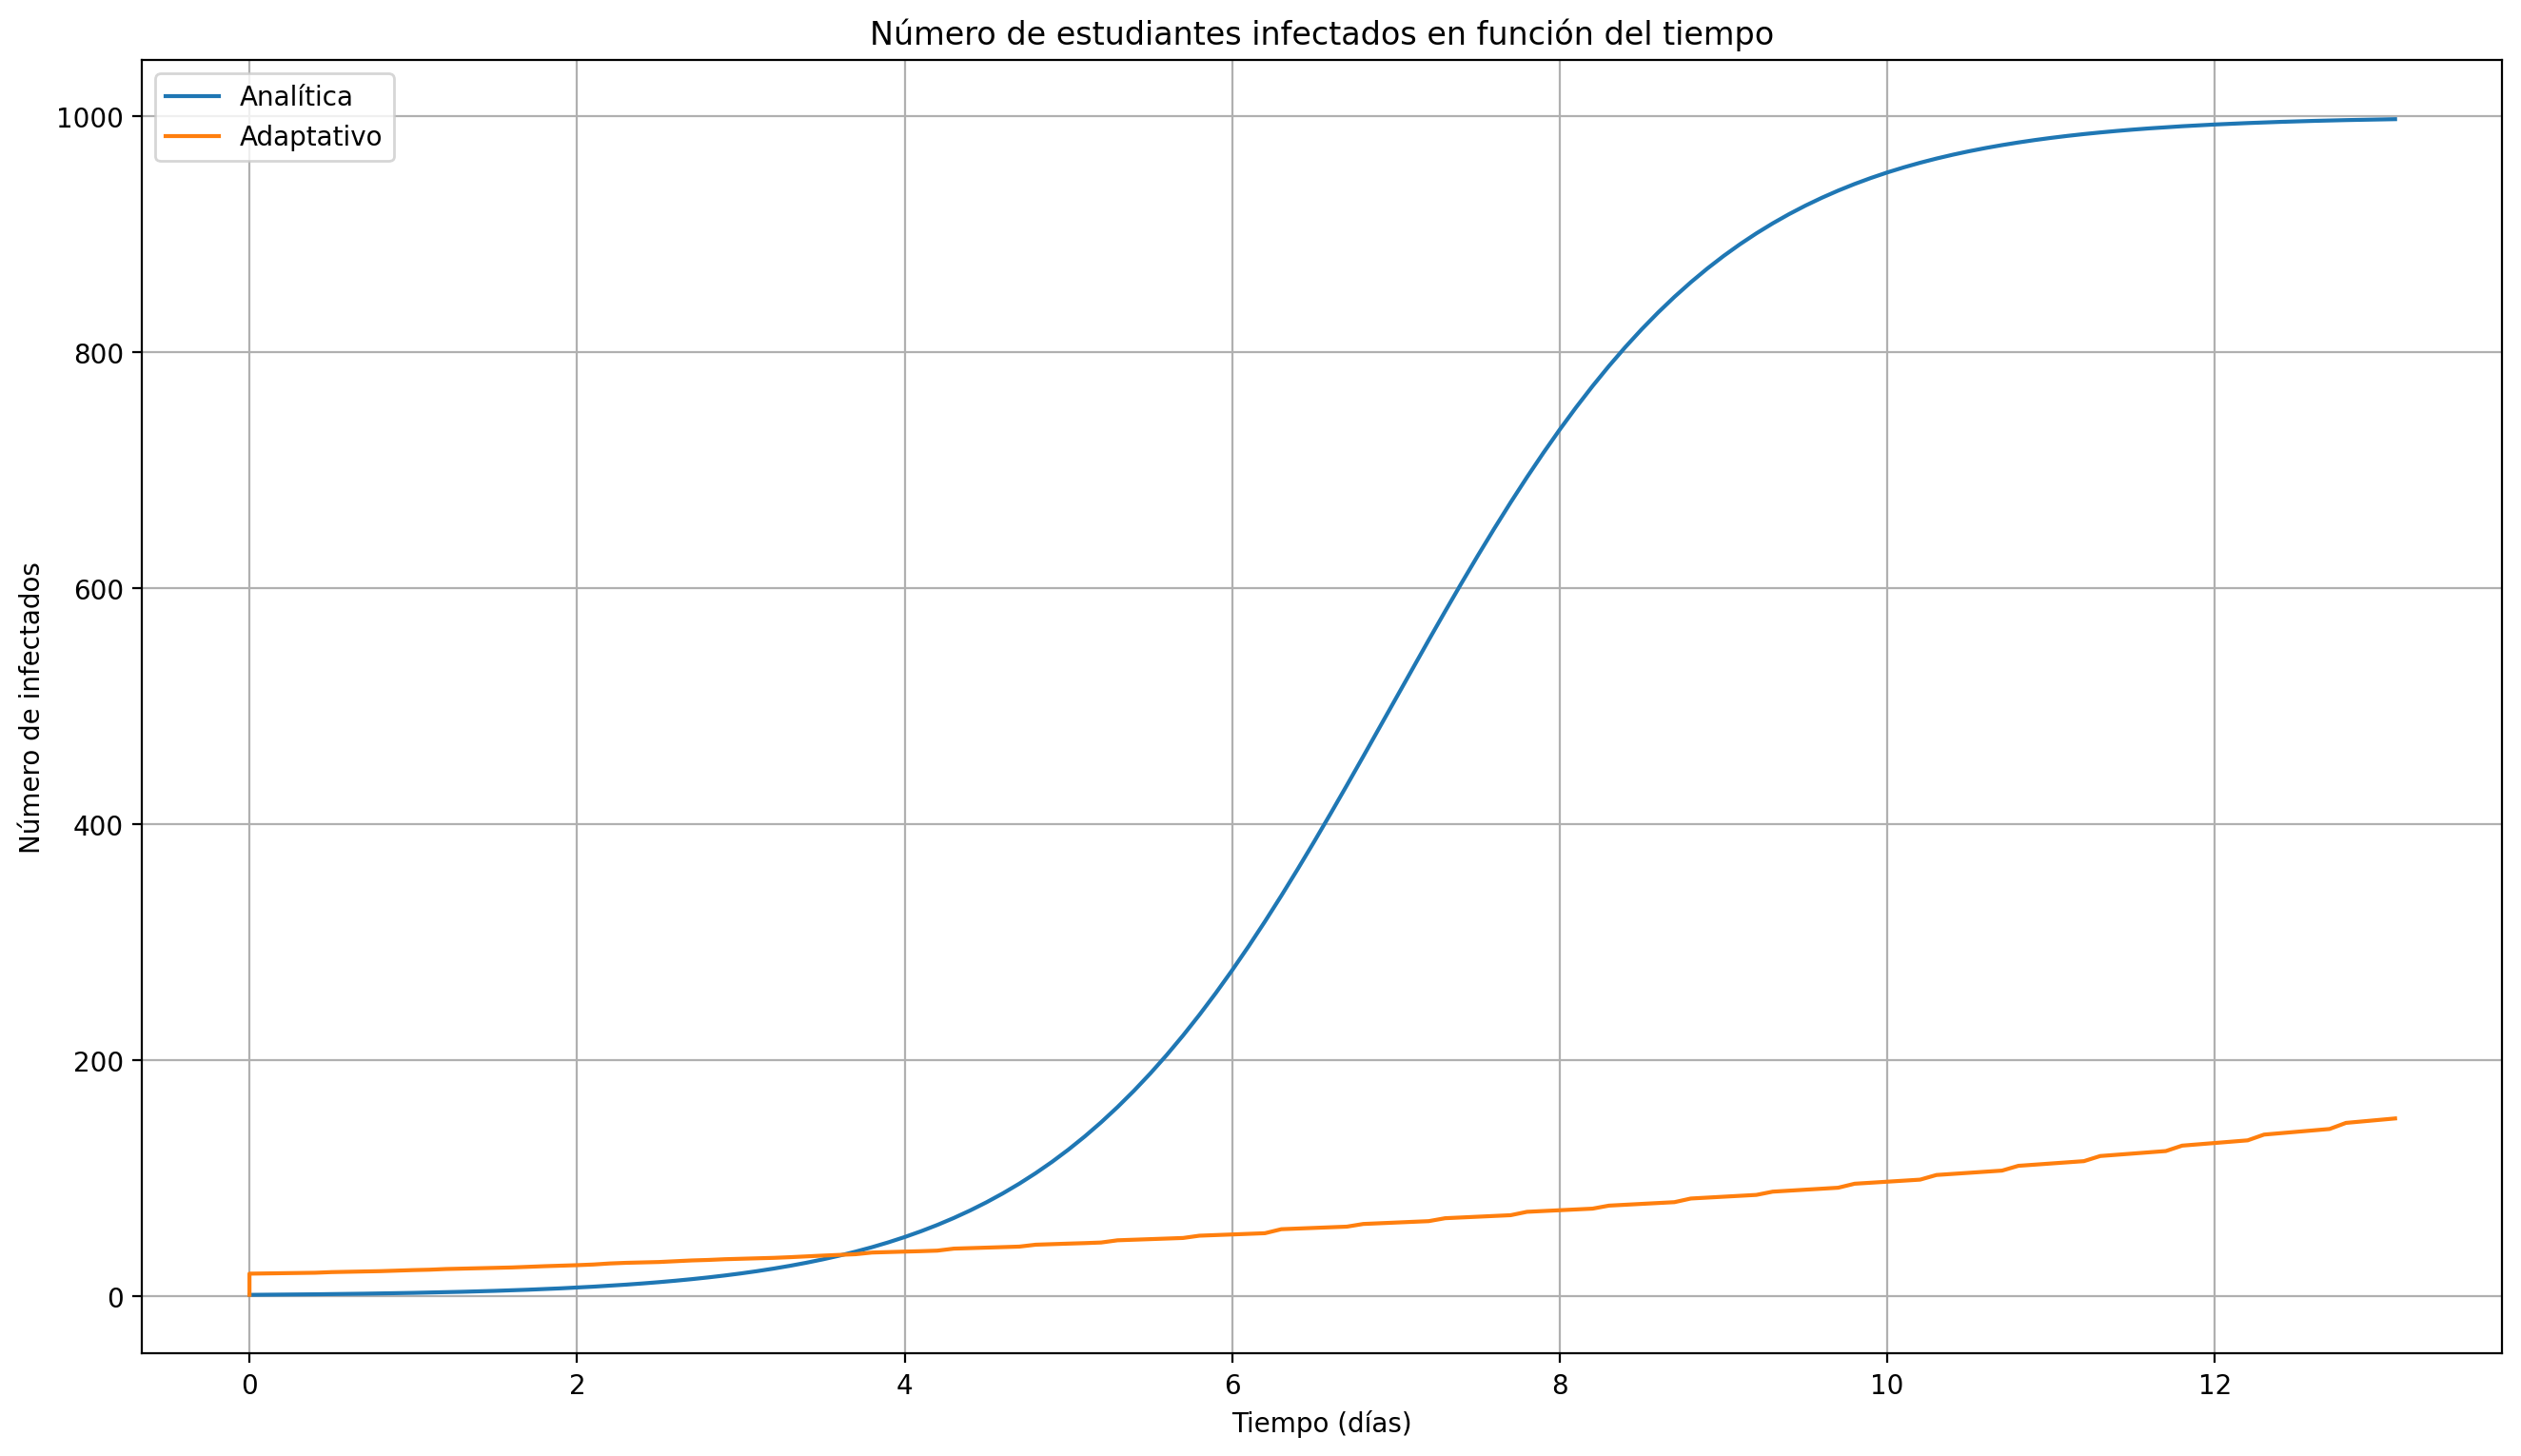

In [42]:
plt.figure(figsize=(16,9), dpi=200)
plt.title("Número de estudiantes infectados en función del tiempo")
plt.xlabel("Tiempo (días)")
plt.ylabel("Número de infectados")
plt.grid()

plt.plot(tada, yt, label="Analítica")
plt.plot(tada, yada, label = "Adaptativo")

plt.legend()